# Incremental Learning Implementation

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1337) # for reproducibility


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## 0. Functions

In [101]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')

    return model

def update_dist(prev_dist, dist):
    """Return updated mean and standard deviation when combining two distributions. Assuming that the 
    two distributions have the same population"""
    from math import sqrt
    
    if not prev_dist:
        return dist
    
    mu1 = prev_dist[0]
    s1 = prev_dist[1]
    n1 = prev_dist[2]
    
    mu2 = dist[0]
    s2 = dist[1]
    n2 = dist[2]
    
    mu = (mu1*n1+mu2*n2)/(n1 + n2)
    
    Ex_2 = ((mu1**2 + s1**2)*n1 + (mu2**2 + s2**2)*n2)/(n1 + n2)
    
    s = sqrt(Ex_2 - mu**2)
    
    return (mu, s, n1 + n2)
    

def train(current_weights, X, time_axis, time_range, prev_dist):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    end_index = np.argmax(time_axis > time_range[1])
    
    X_train = X[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=20, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    loss_dist = (np.mean(loss), np.std(loss), X_train.size)
    
    dist = update_dist(prev_dist, loss_dist)
    
    return new_weights, dist

def trigger(current_weights, X, time_axis, time_range, prev_dist):
    
    print("Triggering for section: ", time_range)
    print("Using distribution:", prev_dist)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    print("Trigger start index: ", start_index)
    print("Trigger end index: ", end_index)
    
    X_test = X[start_index:end_index]
    time_test = time_axis[start_index:end_index]
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    #Quantify how much each data point is far away from the distribution
    sd_test_loss = (test_loss-prev_dist[0])/prev_dist[1] #prev_dist = (mean, sds) 
    
    #Find the trigger time
    trigger_index = np.argmax(sd_test_loss > 100)
    
    if  trigger_index != 0: 
        return time_test[trigger_index]
    else:
        return None
    
    return trigger_time
    

def simulation(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_dist = None
    dist = None
    
    #Create a model
    model = create_model()
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Sequentially go through the data
    for i in range(num_section):
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        
        if i == 0:
            continue
        elif i == 1:
            #Train on the first segment
            time_range = (None, -section_size*(num_section - i))
            new_weights, dist = train(current_weights, X, time_axis, time_range, prev_dist)
        else:
            #Set the model to newly trained model
            model.set_weights(new_weights)
            
            #Set previous distrubution to the newly trained disttribution
            prev_dist = dist
            
            #Selecting appropriate time range for training and triggering
            train_time_range = (-section_size*(num_section - i + 1), -section_size*(num_section - i))
            trigger_time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
            
            #Train and predict simutaneously
            new_weights, dist = train(current_weights, X, time_axis, train_time_range, prev_dist)
            trigger_time = trigger(current_weights, X, time_axis, trigger_time_range, prev_dist)
            
            if trigger_time:
                print("Triggered at: ", trigger_time)
                return trigger_time
                

In [13]:
simulation("./data/Ramp22/", 5, (-25,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
Entering sections:  (-20, -15)
Training for section:  (None, -20)
Start index:  0
End index:  47501
Entering sections:  (-15, -10)
Training for section:  (-20, -15)
Start index:  47501
End index:  97501
Triggering for section:  (-15, -10)
Entering sections:  (-10, -5)
Training for section:  (-15, -10)
Start index:  97501
End index:  147501
Triggering for section:  (-10, -5)
Triggered at:  -9.4435


-9.4435

In [16]:
simulation("./data/Ramp22/", 5, (-25,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
Entering sections:  (-20, -15)
Training for section:  (None, -20)
Start index:  0
End index:  47501
Entering sections:  (-15, -10)
Training for section:  (-20, -15)
Start index:  47501
End index:  97501
Triggering for section:  (-15, -10)
Using distribution: (0.0006072979388297666, 0.0004844603091931605)
Entering sections:  (-10, -5)
Training for section:  (-15, -10)
Start index:  97501
End index:  147501
Triggering for section:  (-10, -5)
Using distribution: (0.0005465077576209433, 0.0004546977345307103)
Triggered at:  -9.8104


-9.8104

In [19]:
simulation("./data/Ramp22/", 5, (-25,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
Entering sections:  (-20, -15)
Training for section:  (None, -20)
Entering sections:  (-15, -10)
Training for section:  (-20, -15)
Triggering for section:  (-15, -10)
Using distribution: (0.0005481045051627814, 0.0004263163962259143, 570012)
Entering sections:  (-10, -5)
Training for section:  (-15, -10)
Triggering for section:  (-10, -5)
Using distribution: (0.0005541357453353145, 0.0004775277222085754, 1170012)
Triggered at:  -8.5056


-8.5056

In [102]:
simulation("./data/Ramp22/", 5, (-25,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
Entering sections:  (-20, -15)
Training for section:  (None, -20)
Entering sections:  (-15, -10)
Training for section:  (-20, -15)
Triggering for section:  (-15, -10)
Using distribution: (0.0005409627012303741, 0.0004095826407791596, 570012)
Trigger start index:  97501
Trigger end index:  147501
Entering sections:  (-10, -5)
Training for section:  (-15, -10)
Triggering for section:  (-10, -5)
Using distribution: (0.0004903758117451143, 0.00039945520282169136, 1170012)
Trigger start index:  147501
Trigger end index:  197501
Entering sections:  (-5, 0)
Training for section:  (-10, -5)
Triggering for section:  (-5, 0)
Us

-0.0142

In [5]:
simulation("./data/Ramp22/", 5, (-25,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
Entering sections:  (-20, -15)
Training for section:  (None, -20)
Entering sections:  (-15, -10)
Training for section:  (-20, -15)
Triggering for section:  (-15, -10)
Using distribution: (0.000607107741421697, 0.0004535388670472368, 570012)
Entering sections:  (-10, -5)
Training for section:  (-15, -10)
Triggering for section:  (-10, -5)
Using distribution: (0.0005312416873722008, 0.0004245339191629945, 1170012)
Triggered at:  -8.135099


-8.135099

## Just need to use the loss distribution of the most recent model

In [3]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')

    return model

def train(current_weights, X, time_axis, time_range, prev_dist):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    end_index = np.argmax(time_axis > time_range[1])
    
    X_train = X[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
        
    scaler = MinMaxScaler()

    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=20, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    dist = (np.mean(loss), np.std(loss))
    
    print("Finished training, distribution of the loss is: ", dist)
    
    return new_weights, dist, scaler

def trigger(current_weights, X, time_axis, time_range, prev_dist, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this distribution for trigger:", prev_dist)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    end_index = np.argmax(time_axis > time_range[1])
    
    X_test = X[start_index:end_index]
    X_test = scaler.transform(X_test) #Scaler the current data
    
    time_test = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, test_loss)
    plt.title("Reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Quantify how much each data point is far away from the distribution
    sd_test_loss = (test_loss-prev_dist[0])/prev_dist[1] #prev_dist = (mean, sds) 
    
    #Find the trigger time
    trigger_index = np.argmax(sd_test_loss > 10)
    
    if  trigger_index != 0: 
        return time_test[trigger_index]
    else:
        return None
    
    return trigger_time
    

def simulation(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_dist = None
    dist = None
    
    #Keeping track of scaler after training
    past_scaler = None
    
    #Create a model
    model = create_model()
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Sequentially go through the data
    for i in range(num_section):
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        print("-------->")
        
        if i == 0:
            continue
        elif i == 1:
            #Train on the first segment
            time_range = (None, -section_size*(num_section - i))
            new_weights, dist, past_scaler = train(current_weights, X, time_axis, time_range, prev_dist)
        else:
            #Set the model to newly trained model
            model.set_weights(new_weights)
            
            #Set previous distrubution to the newly trained disttribution
            prev_dist = dist
            scaler = past_scaler #Set the scaler as well
            
            #Selecting appropriate time range for training and triggering
            train_time_range = (-section_size*(num_section - i + 1), -section_size*(num_section - i))
            trigger_time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
            
            #Train and predict simutaneously
            new_weights, dist, past_scaler = train(current_weights, X, time_axis, train_time_range, prev_dist)
            trigger_time = trigger(current_weights, X, time_axis, trigger_time_range, prev_dist, scaler)
            
            if trigger_time:
                print("Triggered at: ", trigger_time)
                return trigger_time
        
        print("<--------")

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
-------->
Entering sections:  (-20, -15)
-------->
Training for section:  (None, -20)
Finished training, distribution of the loss is:  (0.036730391908698624, 0.025118730322240712)
<--------
Entering sections:  (-15, -10)
-------->
Training for section:  (-20, -15)
Finished training, distribution of the loss is:  (0.020968066464194628, 0.015822621358300162)
Triggering for section:  (-15, -10)
Using this distribution for trigger: (0.036730391908698624, 0.025118730322240712)


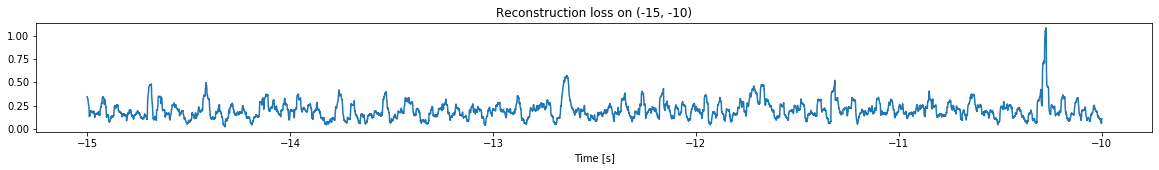

<--------
Entering sections:  (-10, -5)
-------->
Training for section:  (-15, -10)
Finished training, distribution of the loss is:  (0.04199534141794644, 0.029786448502196538)
Triggering for section:  (-10, -5)
Using this distribution for trigger: (0.020968066464194628, 0.015822621358300162)


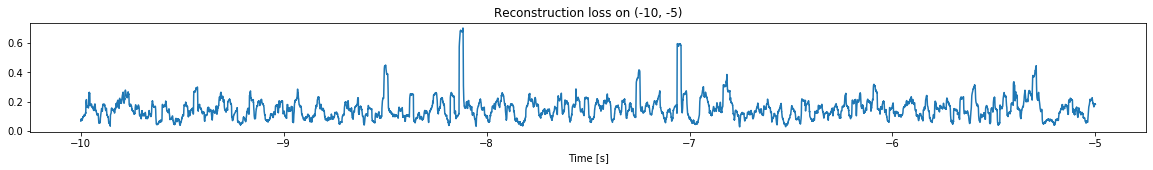

Triggered at:  -9.9751


-9.9751

In [94]:
simulation("./data/Ramp22/", 5, (-25,0))

In [72]:
#SD = 38
simulation("./data/Ramp22/", 5, (-25,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
-------->
Entering sections:  (-20, -15)
-------->
Training for section:  (None, -20)
Finished training, distribution of the loss is:  (0.0005370492756821731, 0.00043365806391623023)
<--------
Entering sections:  (-15, -10)
-------->
Training for section:  (-20, -15)
Finished training, distribution of the loss is:  (0.0005581256472023067, 0.0005829701990937062)
Triggering for section:  (-15, -10)
Using this distribution for trigger: (0.0005370492756821731, 0.00043365806391623023)
<--------
Entering sections:  (-10, -5)
-------->
Training for section:  (-15, -10)
Finished training, distribution of the loss is:  (0.0007

ValueError: operands could not be broadcast together with shapes (0,) (0,12) 

In [77]:
simulation("./data/Ramp22/", 5, (-25,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Number of sections: 5
Entering sections:  (-25, -20)
-------->
Entering sections:  (-20, -15)
-------->
Training for section:  (None, -20)
Finished training, distribution of the loss is:  (0.04494960146531087, 0.03315995871324737)
<--------
Entering sections:  (-15, -10)
-------->
Training for section:  (-20, -15)
Finished training, distribution of the loss is:  (0.021049357873841396, 0.017013994689047917)
Triggering for section:  (-15, -10)
Using this distribution for trigger: (0.04494960146531087, 0.03315995871324737)
Triggered at:  -14.4142


-14.4142

## Investigation of how reconstruction loss in (-5,0) changes when using different models from different scales

In [4]:
#Load data and create the model
X, time_axis = generate_data("./data/Ramp22/", time_range = (-30,0), window = 2000, step = 10)  

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


In [7]:
def train(current_weights, X, time_axis, time_range, past_scaler):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    end_index = np.argmax(time_axis > time_range[1])
    
    X_train = X[start_index:end_index]
    
    #Scaler stuffs
    scaler = past_scaler
    scaler.partial_fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=20, verbose = 0)
    
    new_weights = model.get_weights()
    
    return new_weights, scaler

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')

    return model

def test_1(X, time_axis, time_range = (-30,0)):
    
    section_size = 5
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_dist = None
    dist = None
    
    #Create a model
    model = create_model()
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Keeping tract of reconstruction for each model
    loss_tract = []
    
    #Take out the last section
    last_section_start_index = np.argmax(time_axis > -5)
    X_test = X[last_section_start_index:]
    test_time = time_axis[last_section_start_index:]
    
    #Initialize scaler
    past_scaler = MinMaxScaler()
    
    #Sequentially go through the data
    for i in range(num_section-1): #Don't train on last section (-5,0)
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
        new_weights, scaler = train(current_weights, X, time_axis, time_range, past_scaler)
        
        #Keep track of current weights
        current_weights = new_weights
        
        #Set the model to newly trained model
        model.set_weights(new_weights)
        
        #Do prediction on (-5,0)
        X_test_temp = scaler.transform(X_test)
        X_pred_test = model.predict(X_test_temp)
        
        test_loss = np.mean(np.abs(X_pred_test-X_test_temp), axis = 1)
        
        #Plot the test loss
        plt.figure(figsize=(20,2))
        plt.plot(test_time, test_loss)
        plt.title("Reconstruction loss on (-5,0) with model trained on {}".format(str((-section_size*(num_section - i), -section_size*(num_section - i - 1)))))
        plt.xlabel("Time [s]")
        plt.show()
        
        #Save the mean of test_loss
        loss_tract.append(np.mean(test_loss))
        
        #Set the new scaler to past scaler
        scaler = past_scaler
    
    print("Loss: ", loss_tract)
    #Bar plot
    labels = ['(-30,-25)', '(-25,-20)', '(-20,-15)', '(-15,-10)', '(-10,-5)']
    sections = np.arange(len(labels))
    plt.bar(sections, loss_tract)
    plt.xlabel("Trained on")
    plt.ylabel("Average reconstruction loss on (-5,0)")
    plt.xticks(sections, labels)

Number of sections: 6
Entering sections:  (-30, -25)
Training for section:  (-30, -25)


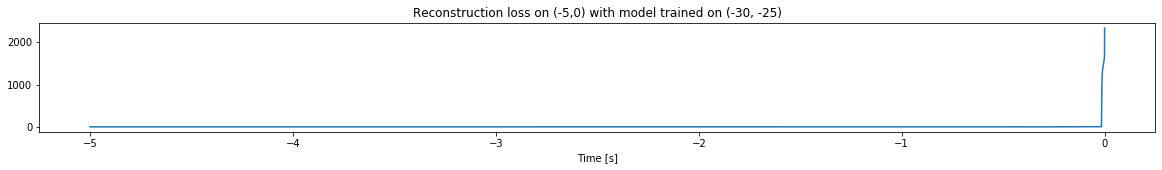

Entering sections:  (-25, -20)
Training for section:  (-25, -20)


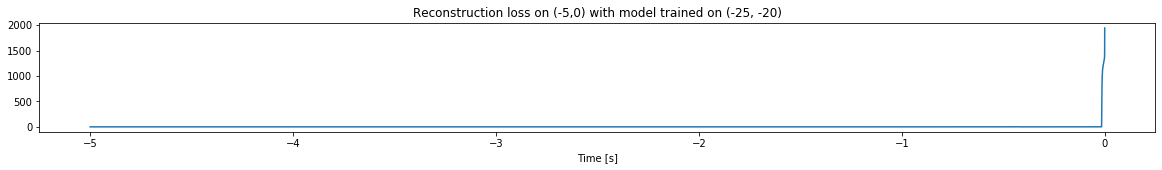

Entering sections:  (-20, -15)
Training for section:  (-20, -15)


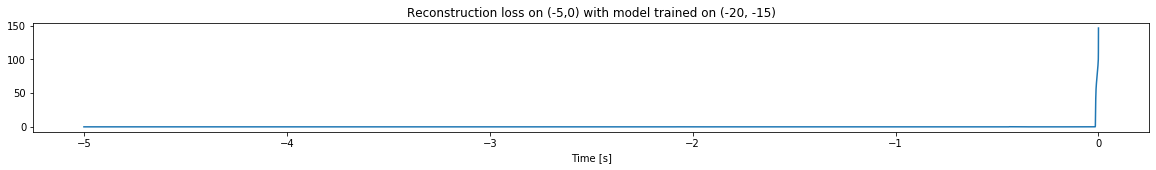

Entering sections:  (-15, -10)
Training for section:  (-15, -10)


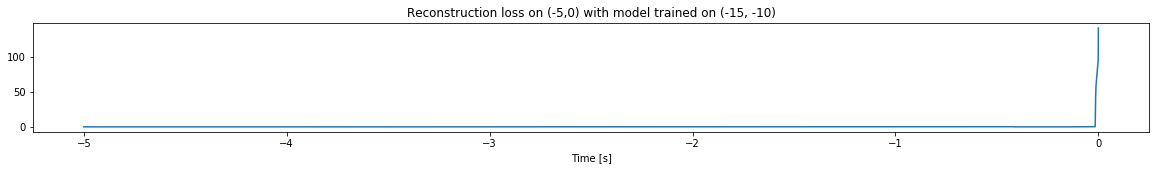

Entering sections:  (-10, -5)
Training for section:  (-10, -5)


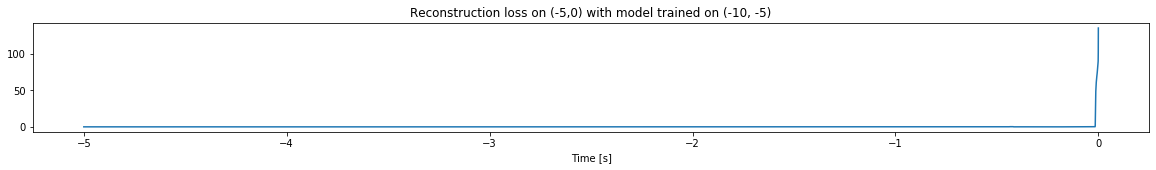

Loss:  [4.151785419479549, 3.505228874859633, 0.23657362051774167, 0.23284080628061915, 0.22295697981505933]


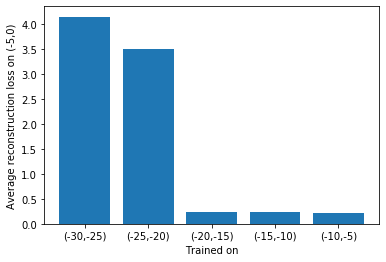

In [8]:
test_1(X, time_axis, time_range = (-30,0))

Number of sections: 6
Entering sections:  (-30, -25)
Training for section:  (-30, -25)
Entering sections:  (-25, -20)
Training for section:  (-25, -20)
Entering sections:  (-20, -15)
Training for section:  (-20, -15)
Entering sections:  (-15, -10)
Training for section:  (-15, -10)
Entering sections:  (-10, -5)
Training for section:  (-10, -5)


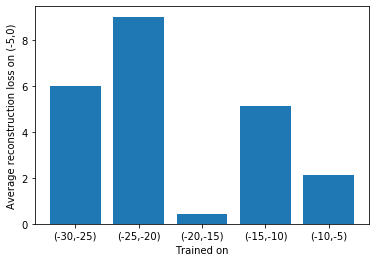

In [86]:
test_1(X, time_axis, time_range = (-30,0))

Number of sections: 6
Entering sections:  (-30, -25)
Training for section:  (-30, -25)
Entering sections:  (-25, -20)
Training for section:  (-25, -20)
Entering sections:  (-20, -15)
Training for section:  (-20, -15)
Entering sections:  (-15, -10)
Training for section:  (-15, -10)
Entering sections:  (-10, -5)
Training for section:  (-10, -5)


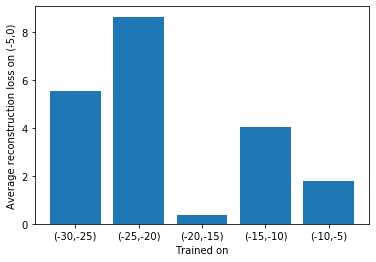

In [87]:
test_1(X, time_axis, time_range = (-30,0))

## Original simple inputs 

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
def load_channel_and_time(dir_path, channel):
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    return data_frame
    
def generate_data_0(dir_path, channel, time_range, window = 1000, step = 10):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the statistics
    #data["Mean"] = data.loc[:, channel].abs().rolling(window=window).mean()
    data["SD"] = data.loc[:, channel].rolling(window=window).std()
    #data["Kurtosis"] = data.loc[:, channel].rolling(window=window).kurt()
    #data["Skew"] = data.loc[:, channel].rolling(window=window).skew()
    
    select_list = ["SD"]
    
    assert data[select_list].to_numpy()[window-1::step].shape[0] == data['time'].to_numpy()[window-1::step].shape[0]
    
    %reset -f in
    
    return data[select_list].to_numpy()[window-1::step], data['time'].to_numpy()[window-1::step]

def generate_data_no_time(dir_path, channel, time_range, window = 1000, step = 10):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the statistics
    #data["Mean"] = data.loc[:, channel].abs().rolling(window=window).mean()
    data["SD"] = data.loc[:, channel].rolling(window=window).std()
    #data["Kurtosis"] = data.loc[:, channel].rolling(window=window).kurt()
    #data["Skew"] = data.loc[:, channel].rolling(window=window).skew()
    
    select_list = ["SD"]
    
    %reset -f in
    
    return data[select_list].to_numpy()[window-1::step]

def generate_data_all_sensors(dir_path, time_range, window = 1000, step = 10):
    
    ai0, time = generate_data(dir_path, "ai0", time_range = time_range, window = window, step = step)
    ai1 = generate_data_no_time(dir_path, "ai1", time_range = time_range, window = window, step = step)
    ai2 = generate_data_no_time(dir_path, "ai2", time_range = time_range, window = window, step = step)
    ai3 = generate_data_no_time(dir_path, "ai3", time_range = time_range, window = window, step = step)
    ai4 = generate_data_no_time(dir_path, "ai4", time_range = time_range, window = window, step = step)
    
    #Multiply them all together
    product_var = ai0*ai1*ai2*ai3*ai4
    
    
    all_channels = np.concatenate((ai0,ai1,ai2,ai3,ai4,product_var), axis = 1)
    
    %reset -f in
    
    return all_channels, time

def plot_moving_mean(dir_path, channel, time_range, window = 1000, step = 10):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the mean
    data["Mean"] = data.loc[:, channel].abs().rolling(window=window).mean()
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(data['time'].to_numpy()[window-1::step], data["Mean"].to_numpy()[window-1::step], label = "Mean of abs(data)")
    plt.legend(loc = "upper right")
    plt.xlabel("Time (s)")
    plt.title("Sensor {}'s moving mean".format(channel))
    
    %reset -f in
    
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data
    
def plot_product_mean(dir_path, time_range, window = 1000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range)
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range)["ai1"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range)["ai2"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range)["ai3"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range)["ai4"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    time_axis = ai0['time'].to_numpy()[window-1::step]
    
    ai0 = ai0["ai0"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, product)
    plt.xlabel("Time (s)")
    plt.title("Product of moving means")
    
def plot_SD(dir_path, channel, time_range, window = 2000, step = 10):
    
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the mean
    data["SD"] = data.loc[:, channel].abs().rolling(window=window).std()
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(data['time'].to_numpy()[window-1::step], data["SD"].to_numpy()[window-1::step], label = "Standard deviation", color = "red")
    plt.legend(loc = "upper right")
    plt.xlabel("Time (s)")
    plt.title("Sensor {}'s moving standard deviation".format(channel))
    
    %reset -f in


def plot_product_SD(dir_path, time_range, window = 1000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range)
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range)["ai1"].rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range)["ai2"].rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range)["ai3"].rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range)["ai4"].rolling(window=window).std().to_numpy()[window-1::step]
    
    time_axis = ai0['time'].to_numpy()[window-1::step]
    
    ai0 = ai0["ai0"].rolling(window=window).std().to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, product, color = "red")
    plt.xlabel("Time (s)")
    plt.title("Product of moving standard deviations")
    
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range)["ai0"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range)["ai1"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range)["ai2"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range)["ai3"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range)["ai4"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range)["ai0"].rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range)["ai1"].rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range)["ai2"].rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range)["ai3"].rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range)["ai4"].rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label
    

def generate_data(dir_path, time_range, window = 2000, step = 10):
    
    moving_mean = generate_mean_data(dir_path, time_range, window = 2000, step = 10)
    moving_sd = generate_sd_data(dir_path, time_range, window = 2000, step = 10)
    time_label = load_time_label(dir_path, time_range, window = 2000, step = 10)
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    %reset -f in
    
    return all_data, time_label

In [3]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-450, -350), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-40, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (999800, 12)
X_test's shape:  (399800, 12)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                84        
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 899820 samples, validate on 99980 samples
Epoch 1/50
899820/899820 [==============================] - 6s 6us/step - loss: 1.5963e-04 - val_loss: 1.3539e-04
Epoch 2/50
899820/899820 [==============================] - 4s 4us/step - loss: 3.7399e-05 - val_loss: 1.0403e-04
Epoch 3/50
899820/899820 [==============================] - 4s 4us/step - loss: 3.1228e-05 - val_loss: 9.2997e-05
Epoch 4/50
899820/899820 [==============================] - 4s 5us/step - loss: 2.8436e-05 - val_loss: 9.5951e-05
Epoch 5/50
899820/899820 [==============================] - 4s 5us/step - loss: 2.6146e-05 - val_loss: 9.6265e-05
Epoch 6/50
899820/899820 [==============================] - 4s 5us/step - loss: 2.4897e-05 - val_loss: 8.2612e-05
Epoch 7/50
899820/899820 [==============================] - 4s 4us/step - loss: 2.4186e-05 - val_loss: 8.1993e-05
Epoch 8/50
899820/899820 [==============================] - 4s 4us/step - loss: 2.3647e-05 - val_loss: 7.8838e-05
Epoch 9/50
899820/899820 [===========

In [7]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [16]:
X_pred_test = model.predict(X_test)
test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

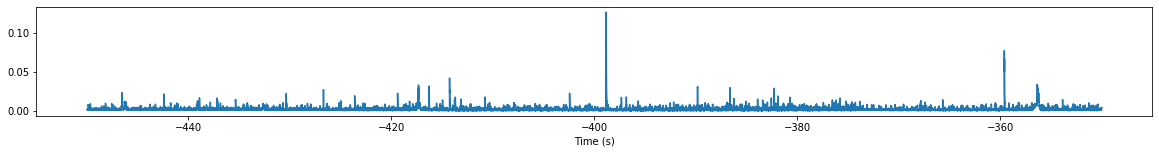

In [12]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
#plt.ylim([0, 3])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

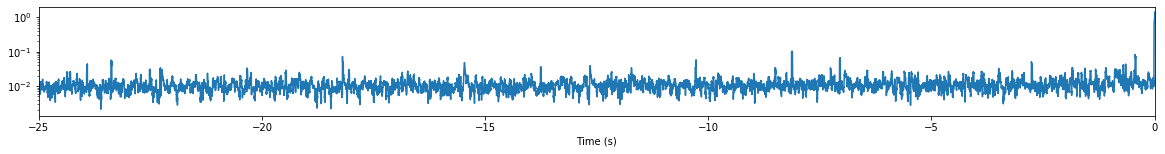

In [15]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
#plt.ylim([0, 3])
plt.yscale("log")
plt.xlim([-25,0])
plt.xlabel("Time (s)")

In [24]:
section_test_loss = test_loss[(test_time > -25) & (test_time < 0)]

In [32]:
loss_means = []

for i in range(5):
    time_range = (-(5-i)*5,-(5-i-1)*5)
    print(time_range)
    start_index = np.argmax(test_time > time_range[0])
    end_index = np.argmax(test_time > time_range[1])
    if i == 4:
        end_index = None
    
    
    print((start_index, end_index))
    loss_means.append(np.mean(test_loss[start_index:end_index]))    

(-25, -20)
(149801, 199801)
(-20, -15)
(199801, 249801)
(-15, -10)
(249801, 299801)
(-10, -5)
(299801, 349801)
(-5, 0)
(349801, None)


In [33]:
loss_means

[0.01061808910145602,
 0.010808520545776376,
 0.011107481469574793,
 0.011997024139118285,
 0.015498558556717288]

([<matplotlib.axis.XTick at 0x7f79a0281210>,
 <a list of 5 Text xticklabel objects>)

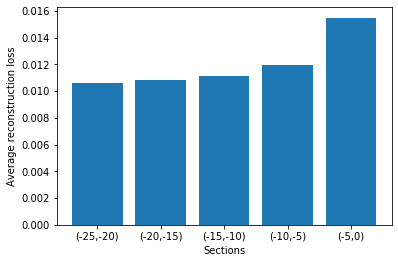

In [49]:
labels = ['(-25,-20)', '(-20,-15)', '(-15,-10)', '(-10,-5)', '(-5,0)']
sections = np.arange(len(labels))
fig, ax = plt.subplots()
plt.bar(sections, loss_means)
plt.xlabel("Sections")
plt.ylabel("Average reconstruction loss")
plt.xticks(sections, labels)